In [6]:
from langgraph.graph import MessagesState
from langchain_cerebras import ChatCerebras
from dotenv import load_dotenv
from langchain_core.messages import HumanMessage, RemoveMessage
from langgraph.graph import StateGraph, START
from langgraph.checkpoint.memory import InMemorySaver

In [8]:
load_dotenv()

True

In [7]:
model=ChatCerebras(model='llama-3.3-70b')

In [9]:
class ChatState(MessagesState):
    summary: str

In [10]:
def summarize_conversation(state: ChatState):

    existing_summary = state["summary"]

    # Build summarization prompt
    if existing_summary:
        prompt = (
            f"Existing summary:\n{existing_summary}\n\n"
            "Extend the summary using the new conversation above."
        )
    else:
        prompt = "Summarize the conversation above."

    messages_for_summary = state["messages"] + [
        HumanMessage(content=prompt)
    ]

    response = model.invoke(messages_for_summary)

    # Keep only last 2 messages verbatim
    messages_to_delete = state["messages"][:-2]

    return {
        "summary": response.content,
        "messages": [RemoveMessage(id=m.id) for m in messages_to_delete],
    }

In [ ]:
def chat_node(state: ChatState):
    messages = []

    if state["summary"]:
        messages.append({
            "role": "system",
            "content": f"Conversation summary:\n{state['summary']}"
        })

    messages.extend(state["messages"])

    print(messages)

    response = model.invoke(messages)
    return {"messages": [response]}

In [12]:
def should_summarize(state: ChatState):
    return len(state["messages"]) > 6

In [13]:
builder = StateGraph(ChatState)

builder.add_node("chat", chat_node)
builder.add_node("summarize", summarize_conversation)

builder.add_edge(START, "chat")

builder.add_conditional_edges(
    "chat",
    should_summarize,
    {
        True: "summarize",
        False: "__end__",
    }
)

builder.add_edge("summarize", "__end__")



In [14]:
checkpointer = InMemorySaver()
graph = builder.compile(checkpointer=checkpointer)

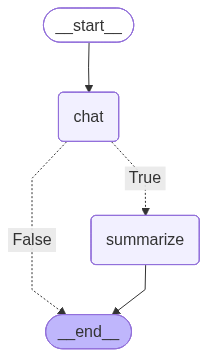

In [15]:
graph

In [16]:
config = {"configurable": {"thread_id": "t1"}}

def run_turn(text: str):
    out = graph.invoke({"messages": [HumanMessage(content=text)], "summary": ""}, config=config)
    return out

In [17]:
# gives the current version of the state
def show_state():
    snap = graph.get_state(config)
    vals = snap.values
    print("\n--- STATE ---")
    print("summary:", vals.get("summary", ""))
    print("num_messages:", len(vals.get("messages", [])))
    print("messages:")
    for m in vals.get("messages", []):
        print("-", type(m).__name__, ":", m.content[:80])

In [18]:
run_turn('Quantum Physics')
show_state()

[HumanMessage(content='Quantum Physics', additional_kwargs={}, response_metadata={}, id='8defaf17-57e3-493d-ae76-e73a75eea63a')]

--- STATE ---
summary: 
num_messages: 2
messages:
- HumanMessage : Quantum Physics
- AIMessage : Quantum physics, also known as quantum mechanics, is a branch of physics that de


In [19]:
run_turn('How is Albert Einstien related?')
show_state()

[HumanMessage(content='Quantum Physics', additional_kwargs={}, response_metadata={}, id='8defaf17-57e3-493d-ae76-e73a75eea63a'), AIMessage(content='Quantum physics, also known as quantum mechanics, is a branch of physics that deals with the behavior of matter and energy at an atomic and subatomic level. At these scales, the classical laws of physics do not apply, and strange, seemingly random phenomena govern the behavior of particles.\n\n**Key Principles of Quantum Physics:**\n\n1. **Wave-Particle Duality**: Quantum objects, such as electrons, can exhibit both wave-like and particle-like behavior depending on how they are observed.\n2. **Uncertainty Principle**: It is impossible to know certain properties of a quantum object, such as its position and momentum, simultaneously with infinite precision.\n3. **Superposition**: Quantum objects can exist in multiple states simultaneously, which is known as a superposition of states.\n4. **Entanglement**: Quantum objects can become "entangled

In [20]:
run_turn('What are some of Einstien"s fampus work')
show_state()

[HumanMessage(content='Quantum Physics', additional_kwargs={}, response_metadata={}, id='8defaf17-57e3-493d-ae76-e73a75eea63a'), AIMessage(content='Quantum physics, also known as quantum mechanics, is a branch of physics that deals with the behavior of matter and energy at an atomic and subatomic level. At these scales, the classical laws of physics do not apply, and strange, seemingly random phenomena govern the behavior of particles.\n\n**Key Principles of Quantum Physics:**\n\n1. **Wave-Particle Duality**: Quantum objects, such as electrons, can exhibit both wave-like and particle-like behavior depending on how they are observed.\n2. **Uncertainty Principle**: It is impossible to know certain properties of a quantum object, such as its position and momentum, simultaneously with infinite precision.\n3. **Superposition**: Quantum objects can exist in multiple states simultaneously, which is known as a superposition of states.\n4. **Entanglement**: Quantum objects can become "entangled

In [21]:
run_turn('Explain special theory of relativity')
show_state()

[HumanMessage(content='Quantum Physics', additional_kwargs={}, response_metadata={}, id='8defaf17-57e3-493d-ae76-e73a75eea63a'), AIMessage(content='Quantum physics, also known as quantum mechanics, is a branch of physics that deals with the behavior of matter and energy at an atomic and subatomic level. At these scales, the classical laws of physics do not apply, and strange, seemingly random phenomena govern the behavior of particles.\n\n**Key Principles of Quantum Physics:**\n\n1. **Wave-Particle Duality**: Quantum objects, such as electrons, can exhibit both wave-like and particle-like behavior depending on how they are observed.\n2. **Uncertainty Principle**: It is impossible to know certain properties of a quantum object, such as its position and momentum, simultaneously with infinite precision.\n3. **Superposition**: Quantum objects can exist in multiple states simultaneously, which is known as a superposition of states.\n4. **Entanglement**: Quantum objects can become "entangled